In [8]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/'
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally


In [9]:
#Import Ruomin's package
from edamame import * 

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import copy

from scipy.io import loadmat, savemat

#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

In [11]:
# # GENERATE + LOAD CSV FILE OF IMAGES:
# from learning_functions import generate_data, load_data
# N= 9
# generate_data(N)
# inputs,onehot_outputs,sample_num,targets=load_data(N)
# target_letters=['z','v','n']
# inv_inputs = np.linalg.pinv(inputs)
# inputs=inputs[:,:-1]


In [12]:
#SIMPLE ROW INPUTS:
np.random.seed(42)
numSamples=10
#SIMPLE ROW INPUTS:
np.random.seed(42)
orig_inputs=np.array((np.array([1,0,1,1,0,1,0]),np.array([0,1,0,1,1,0,1])))
orig_inputs=orig_inputs.astype('double')
samples=[[] for i in range(len(orig_inputs))]
new_inputs=np.array([orig_inputs]*numSamples)

#Pattern without Noise
NoNoiseInputs=[]
for targetClass in range(len(orig_inputs)):
    NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

#Make Noisy variants of simple patterns:
for i in range(len(orig_inputs)):
    for j in range(numSamples):
        randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
        noiseVals=np.random.randint(3, size=randVals)
        temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
        for val in noiseVals:
            temp[val]=np.double(np.random.random(1))
        new_inputs[j][i][new_inputs[j][i]==1]=temp
#         samples[i].append(temp)

#RESHAPE INPUTS INTO numSamplesx2
row1=[]
row2=[]
for i in range(len(new_inputs)):
    row1.append(new_inputs[i][0])
    row2.append(new_inputs[i][1])

inputs=np.array([row1,row2])
inputs=inputs.reshape(numSamples*2,orig_inputs.shape[1])
targets=np.zeros(numSamples*2)
targets[-numSamples:]=1

#change 0 volts to 0.05
minVoltage=0.005
inputs=inputs+minVoltage


In [13]:
# #change 0 volts to 0.05
# minVoltage=0.005
# #Paramater 1 = baseline input voltages
# inputs=inputs+minVoltage
# #instead of +ve bias, make it negative

In [14]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph


2021-12-15 09:51:41,986:INFO:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [15]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
# nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_01399_nj_06084_seed_1159_avl_10.00_disp_01.00_lx_100.00_ly_100.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [16]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

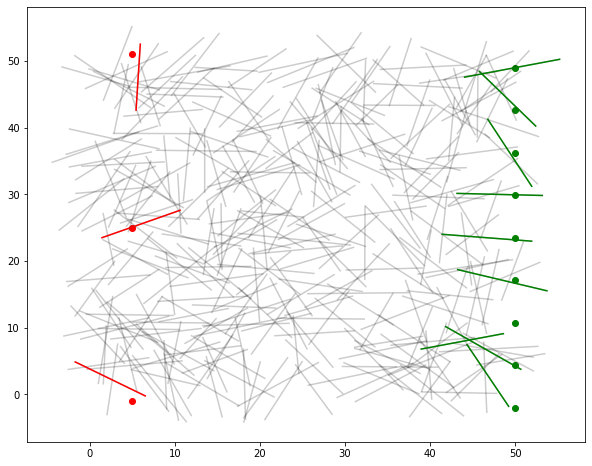

In [17]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*5#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(-1,51,numDrains)#(-1,101,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9

#IN A LINE:
ex=np.ones(numSources)*50#50
ey=np.linspace(-2,49,numSources)#(-2,99,numSources)
#IN A 3X3 GRID:
# middleNWx=int(connectivity.length_x/2)+1
# middleNWy=int(connectivity.length_y/2)-1
# distBwElecs=10
# ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
# ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [31]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))


#remove middle drain and sources for simple patterns:


# elecSource=elecSource[[0,1,2,4,6,7,8]]
elecDrain=elecDrain[[0,-1]]


elecSource=[23,320,74,145, 228, 342, 141]

OG Sources:[311, 320, 74, 145, 228, 342, 141]
OG Drains:[296 339]


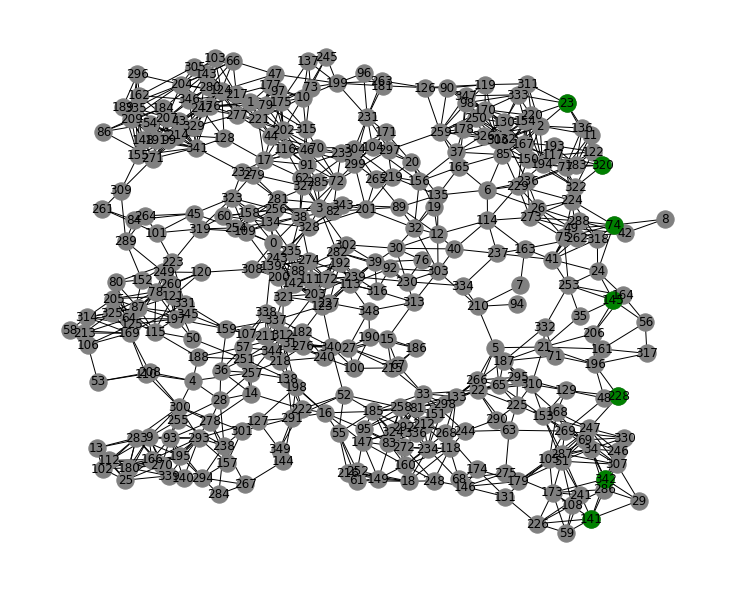

In [32]:
plt.figure(figsize=(10,8))

g=nx.from_numpy_matrix(connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(g)
nx.draw(g,pos=pos,node_color='grey',with_labels=True)

nx.draw_networkx_nodes(g,pos=pos,nodelist=elecSource,node_color='g')
plt.show()

In [202]:
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs


In [203]:

    major_brand     : #This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
    import copy
    stimulus=copy.deepcopy(stim)
    
    Vi        = np.zeros((int(run_time/dt)))
    maxV      = onAmp*0.75
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.1 #change the values here
    grad      = np.zeros((n))
    dsig    = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    
    #vectorised implementation
    cost=calc_cost(outputVals,target_values) 
    
#     if gradOff == False: #
    grad=beta*(outputVals-target_values) 
#     elif gradOff == True: #if we have hit currents target
#         grad=0
    dsig2=dsig.T+(grad*onAmp)
    for i in range(n): # for each drain:
        if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
            stimulus[i].signal=dsig2.T[i]
        
    print('Costs '+str(cost))
    print('Sum Cost '+str((np.sum(cost))))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

#ADD BACKPROP
#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,state,drains,sources,tmpTiming,tmpTargets,run_time=2,dt=0.01,disable_tqdm=False):
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                       stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=disable_tqdm,
                       collapse=True,tmpTiming=tmpTiming,tmpTargets=tmpTargets)  
    #     JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,cost   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[]):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets, lite_mode, disable_tqdm, save_steps, **kwdict)
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost   

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    
    maxV      = onAmp
    n         = num_drain_training #num of drains
    cost      = []
    beta      = 1
    grad      = np.zeros((n)) #set gradients to zero for each epoch  

    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])

    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    #Simulation Run:
    new_time=0
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        
        this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
        
        if tmpTiming[this_time]=='Train':
#             print('--------')
#             print('Training')
#             print('--------\n')
            trainTime=True
        elif tmpTiming[this_time]=='Test':
#             print('--------')
#             print('Testing')
#             print('--------\n') 
            trainTime=False
        
        if trainTime and this_time > 0: #if we are training, change drain voltages, otherwise just use this_stimulus
            this_stimulus[:num_drain_training]=new_stimulus 
            
#             print('in training '+str(this_time))
#         elif this_time > trainTime:
            
        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]
            
        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff
        
        ## BackProp Implementation
        y = Network.electrodeCurrent[this_time,:num_drain_training]
        
        if tmpTargets[this_time] != -1: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent[tarIdx]) # normalize  | | | how do we change max current to be not arbitrary? 
            
        # current method - run simulation before with just that drain and use current as maxCurrent

            # change to threshold 
            d = allTargets[tarIdx]
            dsig = this_stimulus[:num_drain_training]


            #vectorised implementation
            cost.append(calc_cost(y,d))

            if this_time < trainTime: #if we are training, update beta
                #Gradient without considering other electrodes:
        # 
                grad=beta*(y-d) #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]
                #Gradient while considering other electrodes:
        #         for i in range(n): #for each drain 
                    #y = normalised drain current
                    #d = target (1 or 0) e.g. [1,0,0]

        #             grad[i] = beta*(y[i]-d[i]) + sum([beta*(y[j]-d[j]) for j in range(n) if j != i])
                    # i = 1, drain 1 is target, target = 1
                    # i = 2, drain 2 is target, target = 0

                #grad_i = (y_i - d_i) + SUM[ beta*(y_j - d_j) ], j \neq (doesn't equal) i        
                dsig2=np.array(dsig.T+(grad*onAmp))

                dsig2[tmpTargets[this_time]]=0
                new_stimulus=dsig2

                for q in range(n): # for each drain:
                    if dsig2[q] <= maxV and dsig2[q] >= -maxV:
                        new_stimulus[q]=dsig2[q]
                    elif dsig2[q] < -maxV:
                        new_stimulus[q]=-maxV
                    elif dsig2[q] > maxV:
                        new_stimulus[q]=maxV  

                tmp=range(0,niterations,numDT)
             
            else:
                tmp=range(0,niterations,numDT)

            new_time+=1
            
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
        
    return Network,cost



In [204]:
sources = elecSource
drain_pool = elecDrain
allTargets=[[1,0],[0,1]]#[[1,0,0],[0,1,0],[0,0,1]]#onehot_outputs#


In [205]:
# SPLIT INTO TRAINING AND TESTING

In [206]:
targetClassVals=[0,1]
numTestingPerClass = 3
trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-numTestingPerClass],inputs[targets==targetClassVals[1]][:-numTestingPerClass]]).reshape(-1,orig_inputs.shape[1])
testingInputs   = np.array([inputs[targets==targetClassVals[0]][-numTestingPerClass:],inputs[targets==targetClassVals[1]][-numTestingPerClass:]]).reshape(-1,orig_inputs.shape[1])

In [207]:
traininglabels=np.zeros(len(trainingInputs))
traininglabels[:int(len(trainingInputs)/2)]=0
traininglabels[int(len(trainingInputs)/2):int(len(trainingInputs)/2)*2]=1
traininglabels=traininglabels.astype(int)

testinglabels=np.zeros(len(testingInputs))
testinglabels[:int(len(testingInputs)/2)]=0
testinglabels[int(len(testingInputs)/2):int(len(testingInputs)/2)*2]=1
# testinglabels[int(len(testingInputs)/3)*2:]=2
testinglabels=testinglabels.astype(int)

In [221]:

def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],seed=42):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """
    t           = [[] for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    accuracy    = []
    count=0
    for nback in tqdm(nbacks): #how many samples to "remember" in the past before testing
        np.random.seed(seed)
        
        numTestingSample = int(numSamples/5) #how many samples across all nback values
        
        orderTraining = np.random.choice(len(trainingInputs),size=len(trainingInputs),replace=False)
        orderTrainingLabels=traininglabels[orderTraining]
        orderTrainingLabelsNBACK=orderTrainingLabels[::nback]
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(np.random.choice(np.where(testinglabels==label)[0]))
        orderTestingLabels=testinglabels[orderTesting]    
        orderTestingNBACK=np.array(orderTesting)+len(orderTraining) #number of test per nback

         #choose how many samples between testing samples:
        i = nback
        temp=[]
        j=0
        order=[None]*(len(orderTraining))
        order[:len(orderTraining)]=orderTraining
        while j<numTestingSample: #for each training sample
            if i < len(order):
                order.insert(i, orderTesting[j]+len(orderTraining)) #insert training sample at ith position
            temp.append(i) #number of inserts we made
            i += nback+1
            j +=1
            
        #RUN SIM
        N                   = orig_inputs.shape[1]
        numClasses          = 2
        signalType          ='DC'
        num_drain_training  = 2
        num_source_training = N
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        numTrainingSamples  = len(trainingInputs)
        numTestingSamples   = len(testingInputs)
        timing=[]
        i=0
        for val in order: #this method loops through samples in the randomised training order

            #are we training or testing?
            if val in orderTestingNBACK:
                test=True
                train=False
            elif val in orderTraining:
                test=False
                train=True
            #define samples
            if train: #if we're training
                this_sample = trainingInputs[val].copy() #xs
                this_label  = traininglabels[val] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = testingInputs[val-len(orderTraining)].copy() #xs
                this_label  = testinglabels[val-len(orderTraining)] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest
                timing.append('Test')

            targetClassVals=[0,1] 

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-1
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 

            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
            i += 1

        #reshape inputs into 1d:
        tmpSources = np.hstack(np.array(tmpSources))
        tmpTargets = np.hstack(np.array(tmpTargets)).astype(int)
        tmpTiming = np.hstack(np.array(timing))
        # Change voltages
        newSources=tmpSources.copy()

        tmpDrain=[]
        stimulus=[]
        for j in range(num_drain_training): #create stimulus for each drain electrode
            stimulus.append(stimulus__(biasType='Drain',T=dt*len(newSources[j]),dt=dt))

        for j in range(len(tmpSources)): #create stimulus for each source electrode
            stimulus.append(stimulus__(biasType='Custom',T=dt*len(newSources[j]),dt=dt,customSignal=newSources[j]))

        # set_trace()
        signalLen=len(stimulus[0].signal) 
        
        saveStim = stimulus
        #Run simulation
        sim,cost = getNWState_backprop(stimulus,None,drain_pool,sources,tmpTiming,tmpTargets,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)
        #Calculate electrode currents
        simVoltages.append(sim.wireVoltage)
        t[count].append(calcOutputs(sim,sources,drain_pool))
    
    
        #TESTING
        tmp=numDT*nback

        A=np.array(range(tmp,signalLen+1,int(tmp+numDT)))
        B=np.array(range(tmp+numDT,signalLen+1,int(tmp+numDT)))
        c=[]
        for k in range(len(B)):
            c.append(range(A[k],B[k]))
        testTimes=np.array(np.hstack(c))
        l=range(signalLen)
        trainTimes=np.array(np.hstack([m for m in l if m not in testTimes]))
#         set_trace()
        accuracy.append(np.sum(np.argmax([t[count][0][0][testTimes],t[count][0][1][testTimes]],axis=0)==tmpTargets[testTimes])/len(tmpTargets[testTimes]))
        print(accuracy[count])
        
        #Draw:
        #Plot Test labels vs test argmax
#         plt.figure()
#         plt.plot(tmpTargets[testTimes],c='b')
#         plt.plot(np.argmax([t[count][0][0][testTimes],t[count][0][1][testTimes]],axis=0),alpha=0.5,c='r')
#         plt.legend(['Target','Argmax'])

#         plt.yticks([0,1])
#         ax=plt.gca()
#         ax.set_yticklabels(['Drain 1','Drain 2'])      
        
        count+=1
    return t,simVoltages,saveStim,accuracy

In [222]:
# DEFINE PARAMETERS
#Time:
dt      = 0.1
Tlen    = 200 #seconds
timesteps   = int(Tlen/dt)
numDT       = int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

#Amplitude:
allAmpsTraining = [0.5,1,2,5] #Input voltage training
allAmpsTesting  = [0.1,0.2,0.3,0.5] #Input voltage testing
onAmp = allAmpsTraining[2]
onAmpTest = allAmpsTesting[3]

#Other global variables:
num_drain_training = 2
maxCurrent          = [1e-5,1e-5]

#RUN NBACKS
nbacks      = range(1,5)
t           = [None]*10
simVoltages = [None]*10
saveStim    = [None]*10
accuracy    = [None]*10
seeds       =  np.random.choice(10000,size=10,replace=False)


for i in tqdm(range(10)):
    t,simVoltages,saveStim,accuracy[i]=runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,seed=seeds[i])


0.75625



0.79



0.75



0.9933333333333333




0.495



0.608



0.7475



0.9633333333333334




0.7525



0.78



0.6925



0.67




0.50875



0.58



0.51



0.99




0.745



0.982



0.99



0.98




0.74625



0.606



0.98



0.66




0.5075



0.774



0.51



1.0




0.87125



0.608



1.0



0.6633333333333333




0.74625



0.796



0.745



0.98




0.6225



0.786



0.745



0.6766666666666666




Text(0, 0.5, 'Accuracy')

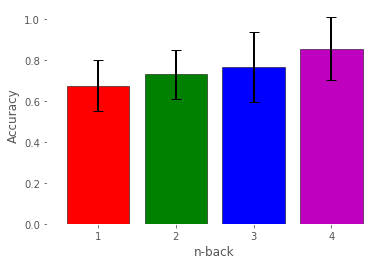

In [223]:
import pandas as pd
plt.style.use('ggplot')

y=np.mean(accuracy,axis=0)
yerr=np.std(accuracy,axis=0)

df=pd.DataFrame({'Mean':y,'STD':yerr})
meansum =df['Mean']
stdsum=df['STD']

fig,ax=plt.subplots(1)
my_colors = ['r','g','b','m']
plot = meansum.plot(kind='bar',yerr=stdsum,color=my_colors,edgecolor='black',grid=False,ax=ax,error_kw=dict(ecolor='k',elinewidth=2,capsize=5),width=0.8,rot=0)
# ax.set_ylim([0.9,1.01])
ax.set_facecolor('white')
ax.set_xticklabels([1,2,3,4])
ax.set_xlabel('n-back')
ax.set_ylabel('Accuracy')

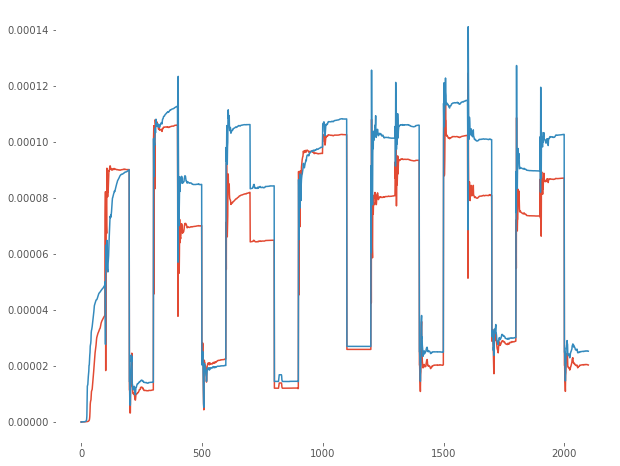

In [192]:
plt.figure(figsize=(10,8))
plt.plot(t[1][0][1])
plt.plot(t[1][0][0])
ax=plt.gca()
ax.set_facecolor('white')

# plt.vlines(A,-1e-5,2e-4,color='k',linestyles='--')
# plt.vlines(B,-1e-5,2e-4,color='k',linestyles='--')


In [151]:
t[0][0]

[array([1.15595743e-07, 2.18447070e-07, 1.03898176e-07, ...,
        2.57996933e-05, 2.58149120e-05, 2.58291914e-05]),
 array([1.16544419e-07, 1.76073120e-07, 1.30553824e-07, ...,
        2.10098756e-05, 2.10157913e-05, 2.10213183e-05])]

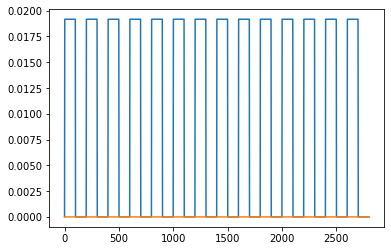

In [895]:
plt.plot(wireVoltage[:,drain_pool])

In [194]:
#Plot all labels vs all argmax
plt.plot(tmpTargets,c='b')
plt.plot(np.argmax([t[1][0][0],t[1][0][1]],axis=0),alpha=0.5,c='r')
plt.legend(['Target','Argmax'])

plt.yticks([0,1])
ax=plt.gca()
ax.set_yticklabels(['Drain 1','Drain 2'])


NameError: name 'tmpTargets' is not defined

In [145]:
t[0][0]

[[array([1.16006497e-07, 2.13913188e-07, 8.91296758e-08, ...,
         2.90415809e-05, 2.90416720e-05, 2.90409111e-05]),
  array([1.07718625e-07, 1.65633554e-07, 9.54394907e-08, ...,
         2.15855166e-05, 2.15857298e-05, 2.15860388e-05])]]

[Text(0, 0, 'Drain 1'), Text(0, 1, 'Drain 2')]

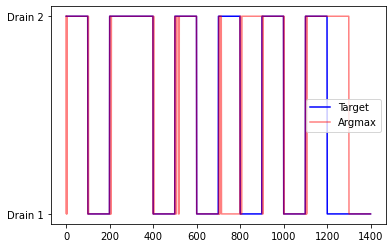

In [902]:
#Plot Train labels vs Train argmax
plt.plot(tmpTargets[trainTimes],c='b')
plt.plot(np.argmax([t[0][trainTimes],t[1][trainTimes]],axis=0),alpha=0.5,c='r')
plt.legend(['Target','Argmax'])

plt.yticks([0,1])
ax=plt.gca()
ax.set_yticklabels(['Drain 1','Drain 2'])


[Text(0, 0, 'Drain 1'), Text(0, 1, 'Drain 2')]

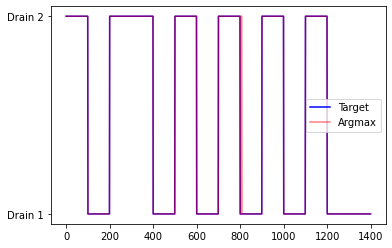

In [904]:
accuracy=np.sum(np.argmax([t[0][testTimes],t[1][testTimes]],axis=0)==tmpTargets[testTimes])/len(tmpTargets[testTimes])

In [905]:
accuracy

0.9964285714285714